# 2024-04-24 webinar Investigating crypto reversal effects.ipynb
https://robotwealth.com/rw-pro-update-2024-04-24-investigating-crypto-reversal-effects/

In [1]:
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = TRUE)

options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tibbletime)
library(roll)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

fs      (1.6.3 -> 1.6.4) [CRAN]
openssl (2.1.1 -> 2.1.2) [CRAN]
brio    (1.1.4 -> 1.1.5) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmphPVE20/remotes1c9e174e9147/RWLab-rwRtools-e73b39d/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.68.tar.gz’



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter




In [11]:
library(glue)

In [3]:
Sys.setenv(TZ = 'UTC')
Sys.timezone()
rwlab_data_auth()

[1] "UTC"

Authorization successful!

In [4]:
raw_prices <- rwRtools::crypto_get_binance_spot_1h()

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 914 Mb )





File successfully transferred


In [6]:
# remove LUNAUSDT from Friday 13 May 2022. Even though it continued to exist after this, there's no way you'd include it in your universe of tradable assets.
prices <- raw_prices %>%
  filter(!(Ticker == "LUNAUSDT" & Datetime >= "2022-05-13"))

library(httr)

# ditch stables and wrapped/leveraged tokens and keep only the data we need

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

stables <- glue::glue("{stables}USDT")

# duplicates and others to remove
to_remove <- glue::glue("{c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')}USDT")

# Remove stablecoins and others
prices <- prices %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  mutate(Ticker = str_replace(Ticker, "USDT$", ""))

head(prices)


Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTC,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETH,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTC,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETH,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTC,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETH,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


In [7]:
# limit universe
trading_universe_size <- 50

universe <- prices %>%
  # just get the top n by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll::roll_mean(`Quote asset volume`, 30*24)) %>%
  na.omit() %>%
  group_by(Datetime) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

head(universe)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,trail_volume,volume_rank,is_universe
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2017-09-16 09:00:00,3816.03,3839.75,3753.00,3753.08,76.39284,288969.0,431,19.24200,72926.08,145466.23,1,TRUE
ETH,2017-09-16 09:00:00,264.99,267.00,255.00,256.00,510.07931,133181.1,490,164.07393,42691.10,78536.56,2,TRUE
BTC,2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.25183,627740.7,778,58.97698,209869.88,146057.03,1,TRUE
ETH,2017-09-16 10:00:00,256.00,257.96,235.51,240.00,1385.45880,340142.1,697,349.70160,86958.16,78956.64,2,TRUE
BTC,2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.72828,409920.0,475,68.05315,246000.25,146487.05,1,TRUE
ETH,2017-09-16 11:00:00,241.00,252.00,236.11,249.99,555.04440,137007.9,387,304.23427,75306.66,78988.53,2,TRUE


In [8]:
lookbacks <- c(3,6,12,18,24)

ibs_IC <- function(lookback) {
  universe %>%
    group_by(Ticker) %>%
    arrange(Datetime) %>%
    mutate(
      ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
      fwd_return_0 = log(lead(Close, 1) / Close),
      fwd_return_1 = log(lead(Close, 2) / lead(Close, 1)),
      fwd_return_2 = log(lead(Close, 3) / lead(Close, 2)),
      fwd_return_3 = log(lead(Close, 4) / lead(Close, 3)),
      fwd_return_4 = log(lead(Close, 5) / lead(Close, 4)),
      fwd_return_5 = log(lead(Close, 6) / lead(Close, 5)),
      fwd_return_6 = log(lead(Close, 7) / lead(Close, 6)),
      fwd_return_7 = log(lead(Close, 8) / lead(Close, 7)),
      fwd_return_8 = log(lead(Close, 9) / lead(Close, 8)),
      fwd_return_9 = log(lead(Close, 10) / lead(Close, 9)),
      fwd_return_10 = log(lead(Close, 11) / lead(Close, 10)),
      fwd_return_11 = log(lead(Close, 12) / lead(Close, 11)),
      fwd_return_12 = log(lead(Close, 13) / lead(Close, 12))
    ) %>%
    filter(is_universe, lubridate::hour(Datetime) == 0) %>% # take out some of the overlaps to keep data smaller
    na.omit() %>%
      pivot_longer(
      cols = starts_with("fwd_return_"),
      names_to = "fwd_window",
      names_prefix = "fwd_return_",
      values_to = "returns"
    ) %>%
    mutate(
      fwd_window = as.integer(fwd_window)  # Convert fwd_window to integer if necessary
    ) %>%
    group_by(fwd_window) %>%
    summarize(IC = cor(ibs,returns)) %>%
    mutate(lookback = lookback)
}

ibsic <- do.call(rbind, lapply(lookbacks, ibs_IC))


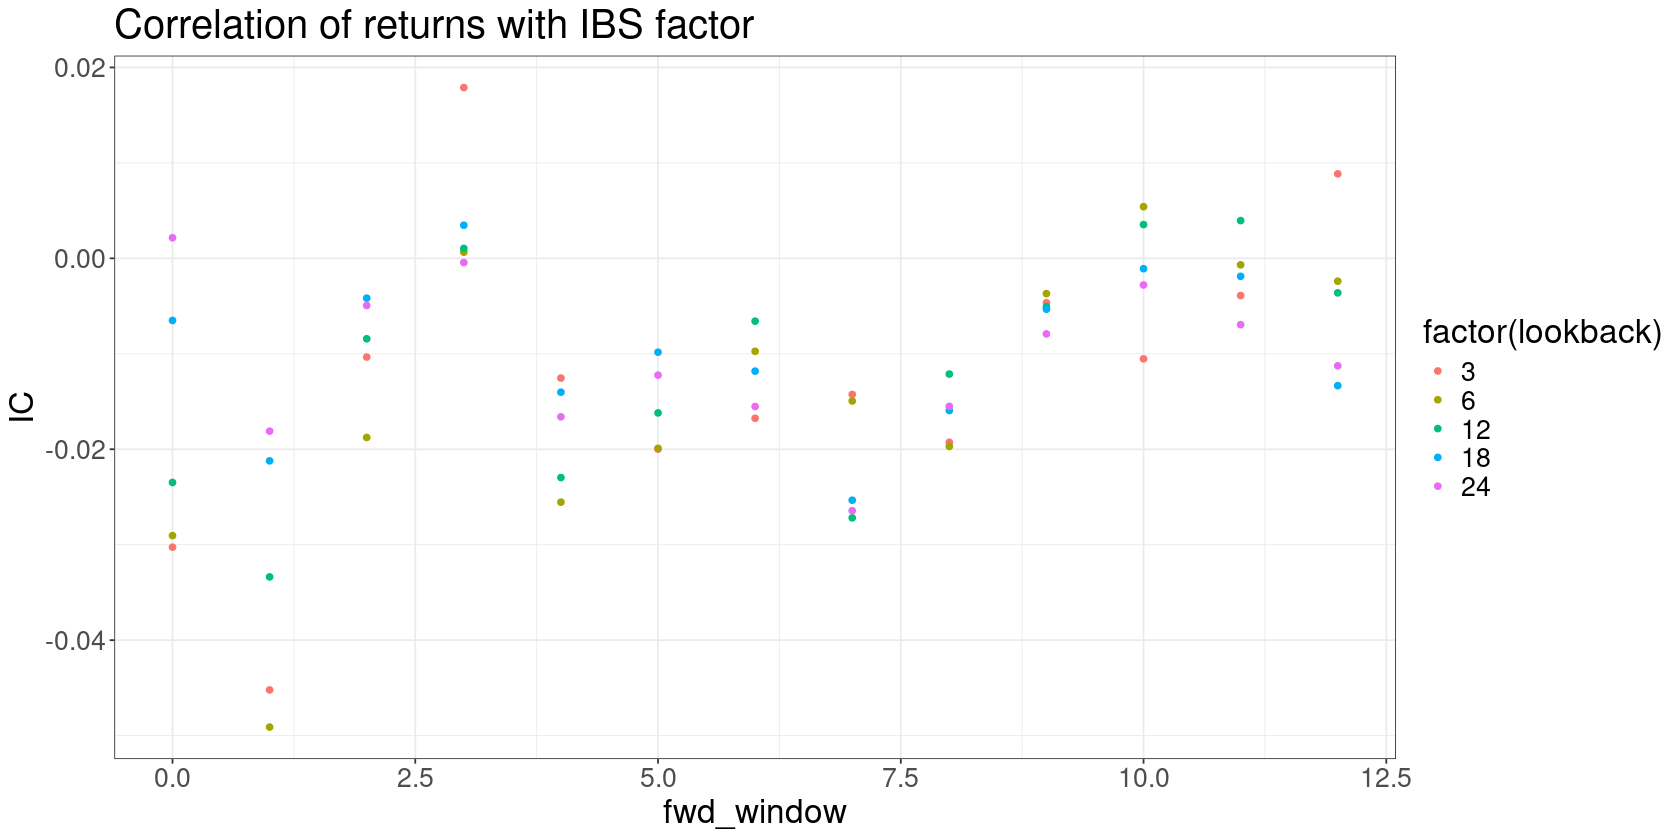

In [9]:
ibsic %>%
  ggplot(aes(x=fwd_window, y=IC, color = factor(lookback))) + geom_point() + ggtitle('Correlation of returns with IBS factor')

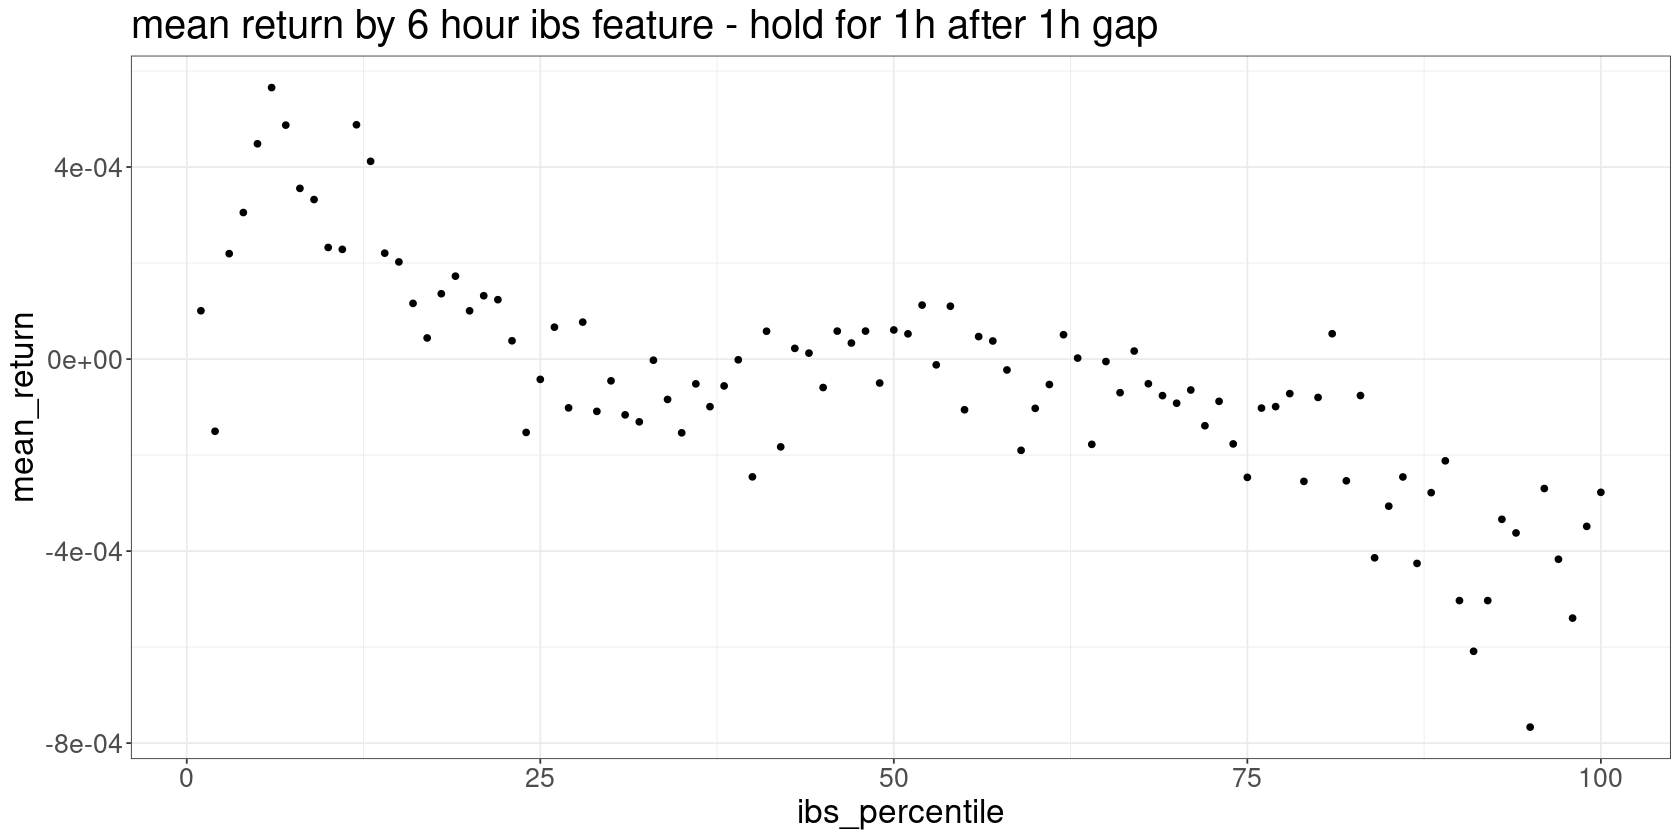

In [12]:
lookback <- 6

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, 2) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  filter(is_universe) %>%
  mutate(ibs_percentile = ntile(ibs, 100)) %>%
  group_by(ibs_percentile) %>%
  summarize(mean_return = mean(fwd_return)) %>%
  ggplot(aes(x=ibs_percentile, y=mean_return)) + geom_point() + ggtitle(glue('mean return by {lookback} hour ibs feature - hold for 1h after 1h gap'))


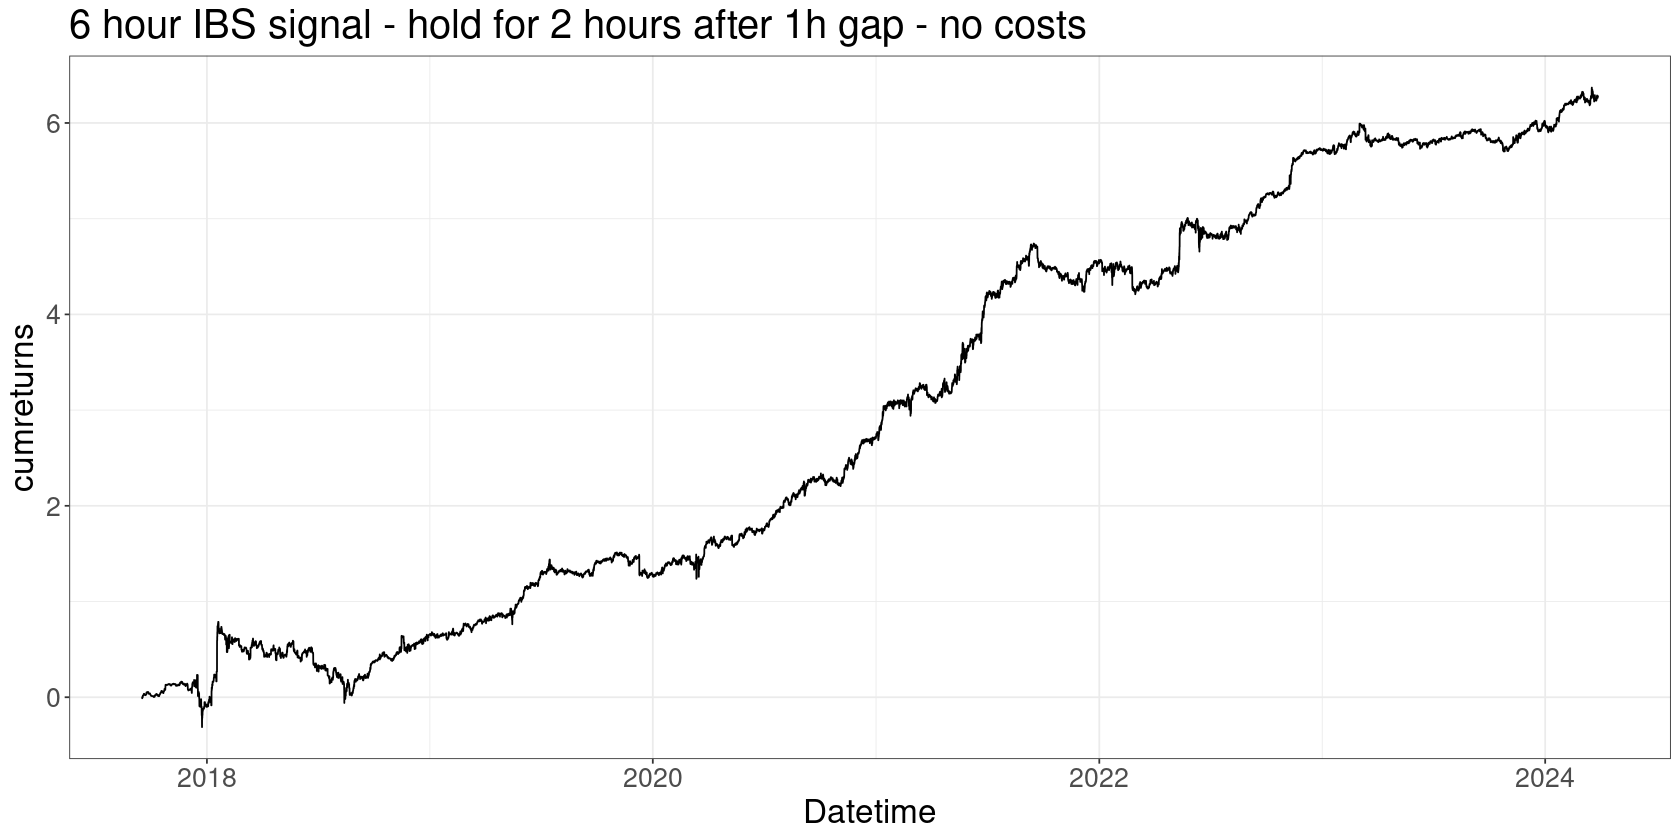

In [13]:
lookback <- 6
hold_period <- 2

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('6 hour IBS signal - hold for 2 hours after 1h gap - no costs')


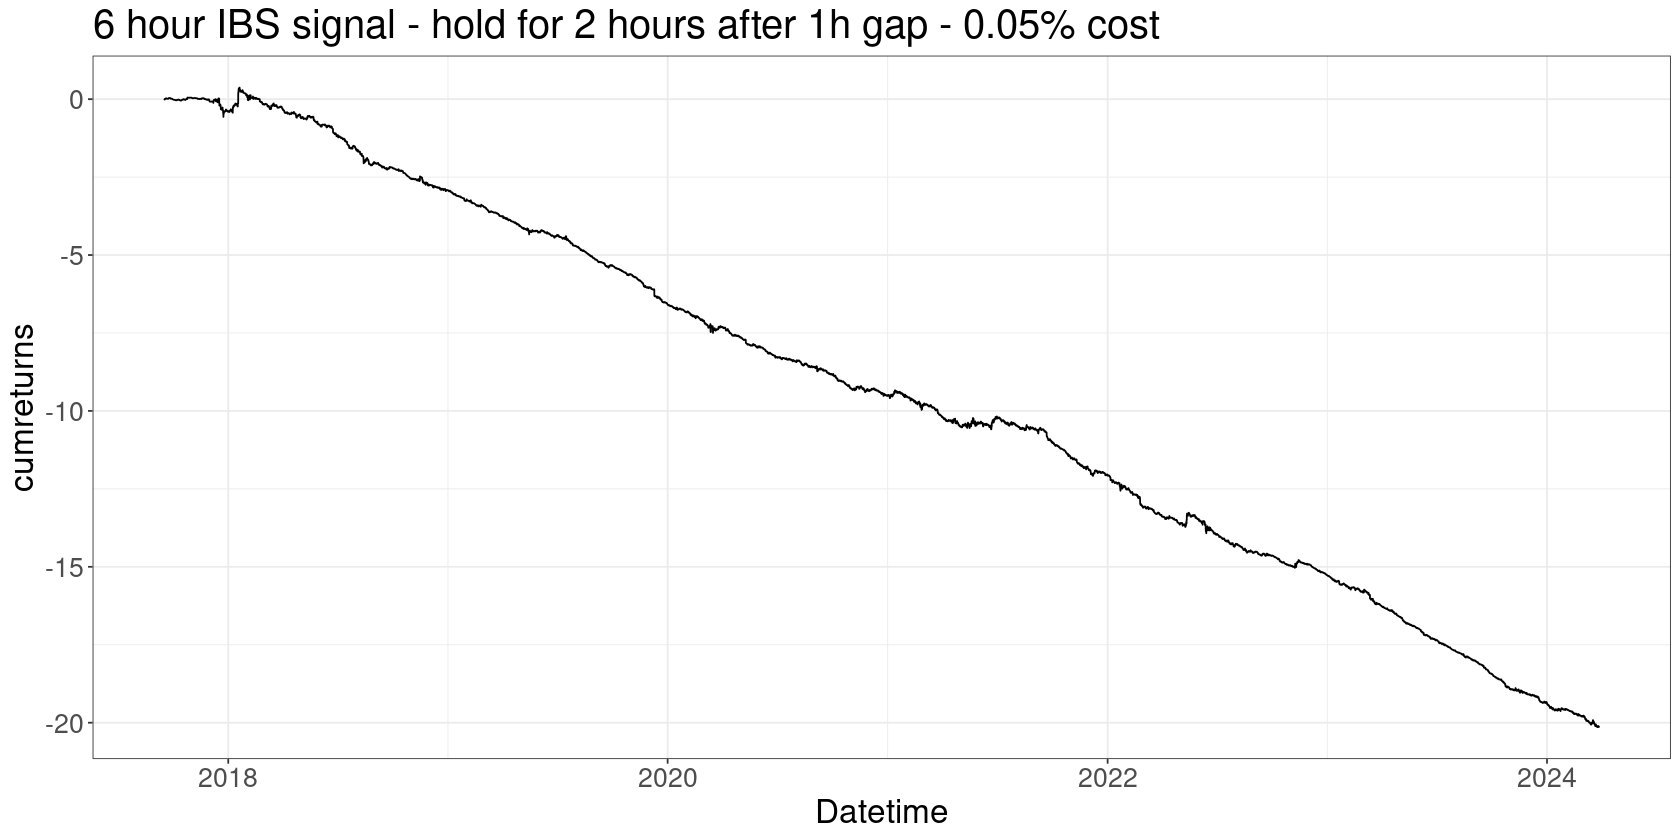

In [14]:
cost <- 0.05/100
lookback <- 6
hold_period <- 2

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1 - cost)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('6 hour IBS signal - hold for 2 hours after 1h gap - 0.05% cost')


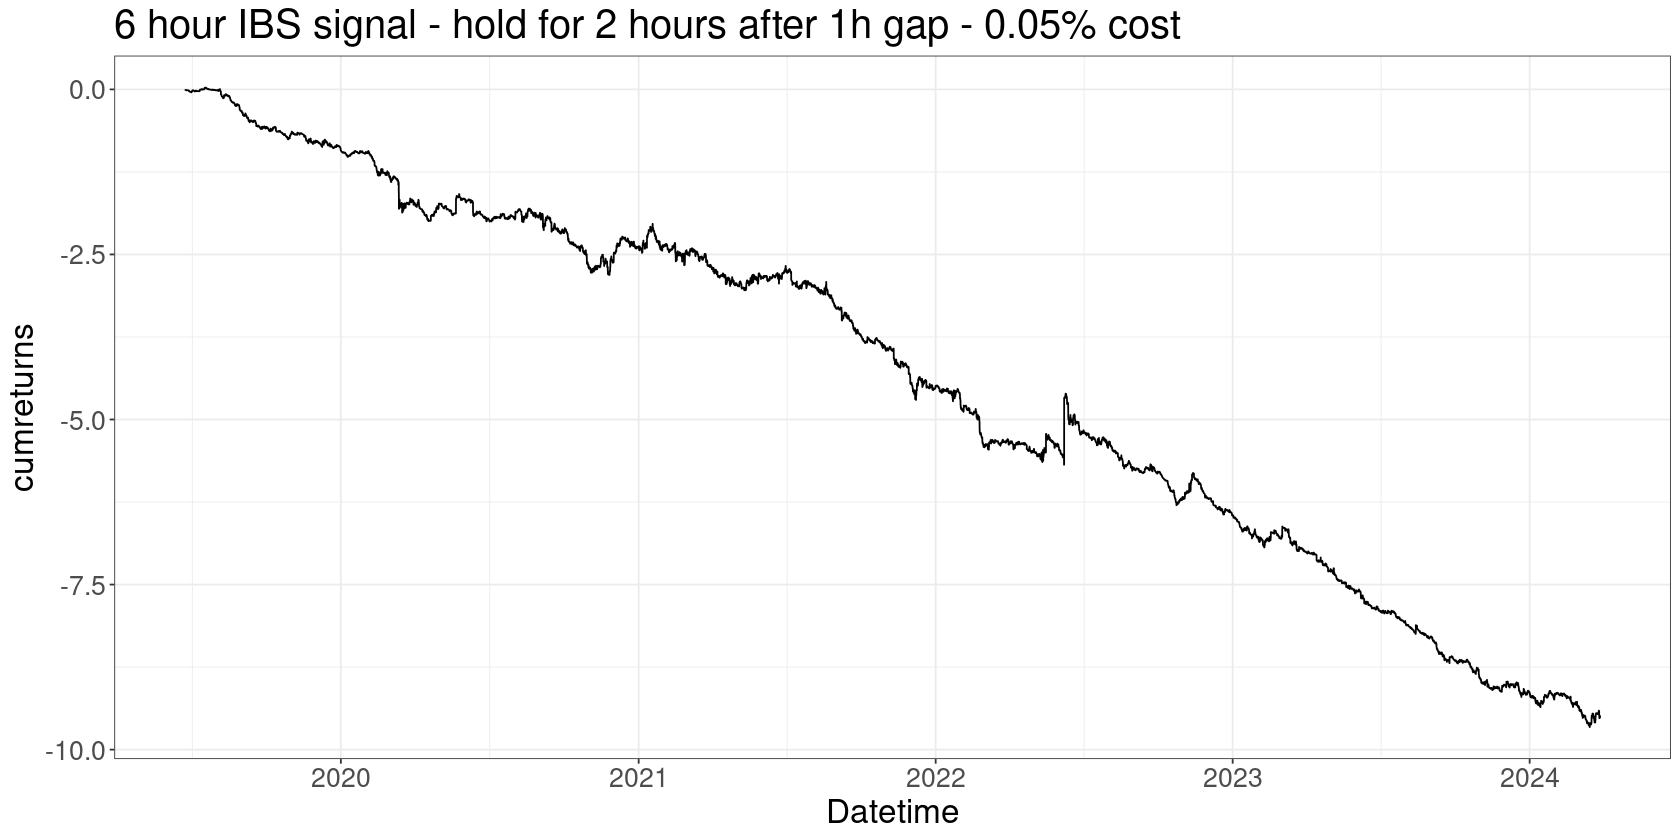

In [15]:
cost <- 0.05/100
lookback <- 6
hold_period <- 2

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  filter(volume_rank > 40) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1 - cost)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('6 hour IBS signal - hold for 2 hours after 1h gap - 0.05% cost')


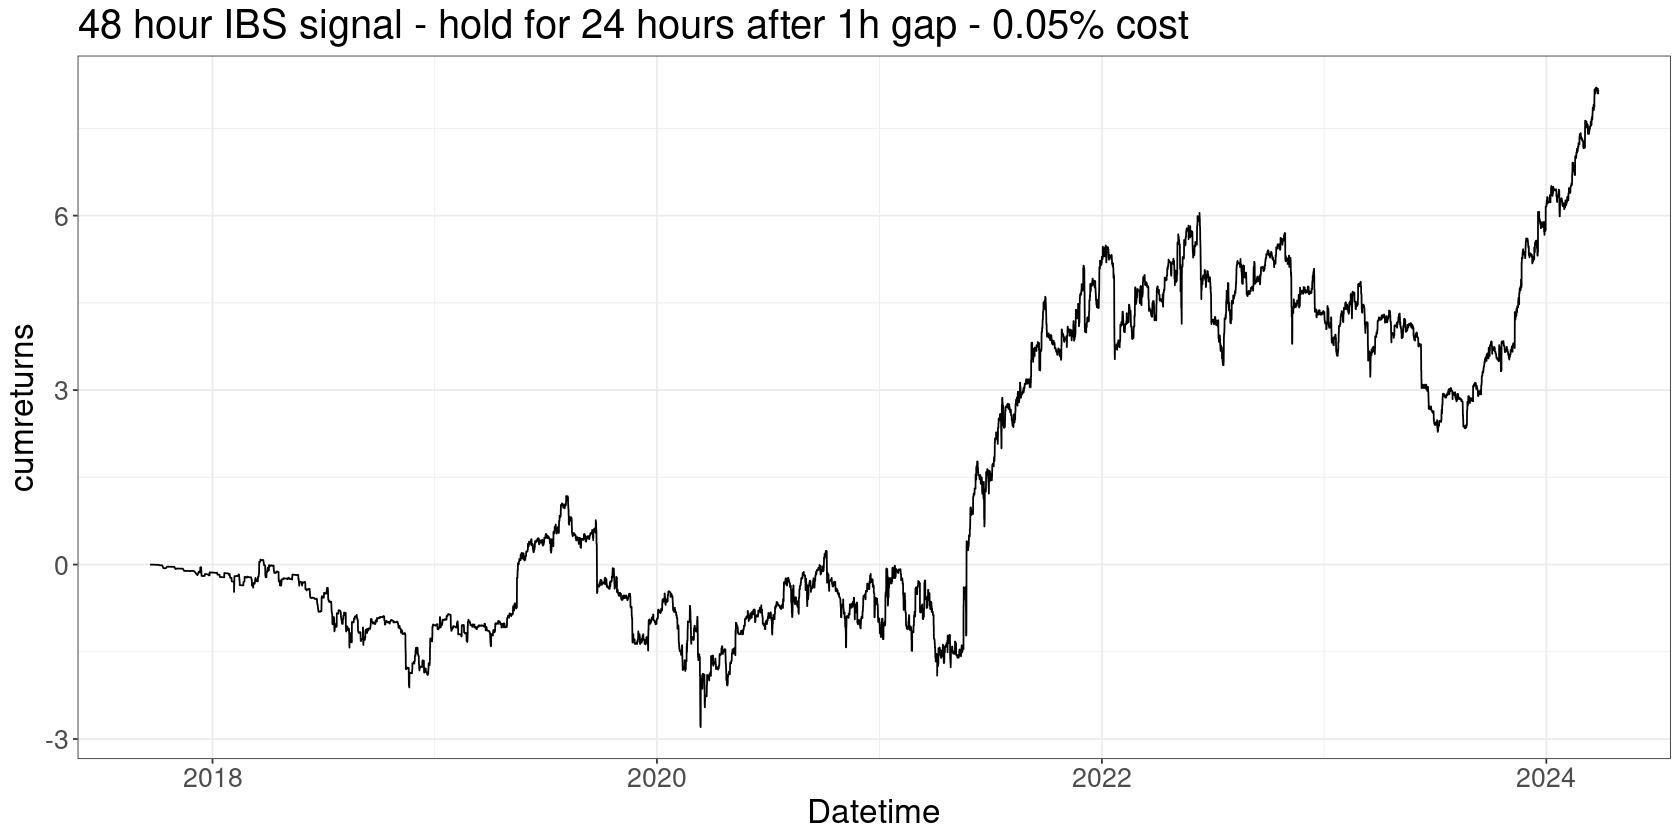

In [16]:
cost <- 0.05/100
lookback <- 48
hold_period <- 24

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  # filter(volume_rank > 40) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1 - cost)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('48 hour IBS signal - hold for 24 hours after 1h gap - 0.05% cost')
